# AA-тест

## Описание задачи:
Для приложения были созданы два новых алгоритма подбора постов, которые будут показаны пользователю в ленте. Перед проведением A/B теста необходимо оценить корректность разбиения нами пользователей на группы.  
  
Метрикой вовлеченности пользователя будет доля лайкнутых им постов от просмотренных постов(будем обозначать эту метрику как CTR, а рассчитывать как отношение количества лайков к количеству просмотров постов пользователем).

<b>Основная гипотеза:</b> CTR экспериментальных групп не отличается.

 - Аудитория была разбита на 4 группы: 2, 3 группы - контрольные, 1 и 4 группы - экспериментальные;
 - Данные для AA-теста собирались с '2022-10-26' по '2022-11-01'
 - Данные для AB-теста собирались с '2022-11-02' по '2022-11-08'


In [1]:
import pandas as pd
import pandahouse as ph
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Получаем данные

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20221120',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

query = '''
SELECT user_id,
        exp_group,
        sum(action = 'like') as like,
        sum(action = 'view') as view
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-10-26' AND toDate(time) <= '2022-11-01'
GROUP BY user_id, exp_group
'''

df = ph.read_clickhouse(query, connection=connection)
df.head()

,user_id,exp_group,like,view
0,18392,1,8,39
1,115383,3,11,36
2,123580,3,15,92
3,131473,2,26,148
4,107323,4,5,26


#### Проверим корректность всех данных:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42585 entries, 0 to 42584
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    42585 non-null  uint32
 1   exp_group  42585 non-null  int8  
 2   like       42585 non-null  uint64
 3   view       42585 non-null  uint64
dtypes: int8(1), uint32(1), uint64(2)
memory usage: 873.5 KB


Пропусков нет, типы данных везде корректны.

In [4]:
sum(df.duplicated())

0

Дублирующихся данных нет.

#### Добавляем интересующую нас метрику

In [5]:
 df['ctr'] = df['like']/df['view']

## Распределение пользователей по группам

In [6]:
 df.groupby('exp_group').user_id.count()

exp_group
0    8484
1    8537
2    8480
3    8569
4    8515
Name: user_id, dtype: int64

Размеры выборок будем считать приблизительно равными.

Проверим есть ли пользователи, одновременно входящие в две группы:

In [7]:
df.groupby('user_id', as_index=False).exp_group.nunique().query('exp_group > 1')

,user_id,exp_group


Группы не пересекаются.

## Распределение CTR в группах

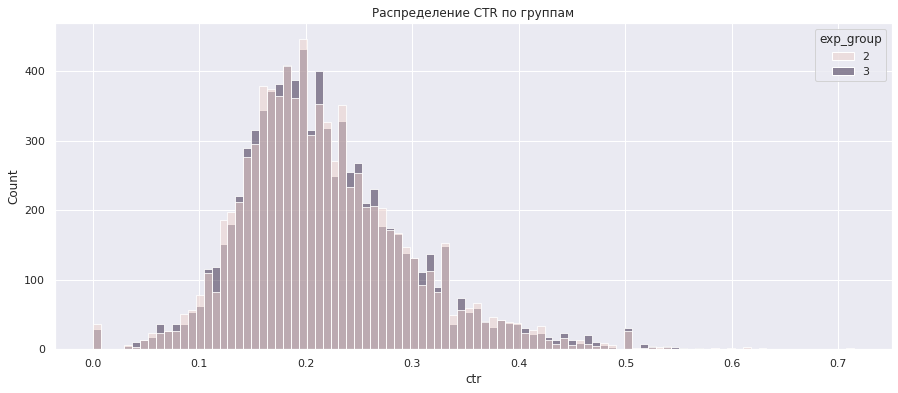

In [8]:
df = df[df['exp_group'].isin([2, 3])]
sns.set(rc = {'figure.figsize':(15,6)})
ax = sns.histplot(df, x='ctr', hue='exp_group')
ax.set_title('Распределение CTR по группам')
plt.show()

Распределения в группах схожи и достаточно близки к нормальному, поэтому мы применим тест Стьюдента для оценки схожести средних CTR.

### Симулирование выборок

Для оцени корректности разбиения пользователей по группам проведем 10 000 AA-тестов, для каждого из которых будут просимулированы случайные выборки по 500 пользователей без повторения из исходных групп.

В рамках каждого из t-тестов будут условия:  
<b>Нулевая гипотеза:</b> средний CTR пользователей в первой и второй группах равен;  
<b>Альтернативная гипотеза:</b> средний CTR пользователей в первой и второй группах не равен;

In [12]:
p_values = []
for _ in range(10000):
    second_group = df[df.exp_group == 2].sample(500)
    third_grouop = df[df.exp_group == 3].sample(500)
    p_values.append(stats.ttest_ind(second_group.ctr, third_grouop.ctr, equal_var=False).pvalue)

 Изучим распределение полученных для каждой из пар подгрупп pvalue от теста Стьюдента.

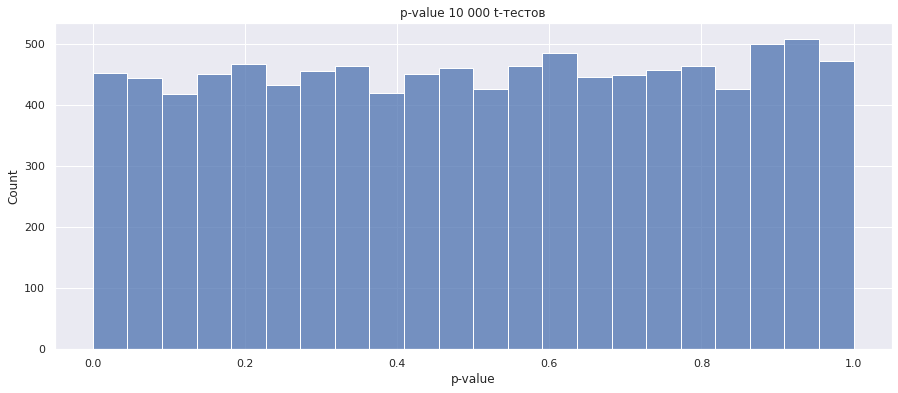

In [13]:
ax = sns.histplot(p_values)
ax.set_title('p-value 10 000 t-тестов')
ax.set_xlabel('p-value')
plt.show()

In [14]:
print("Доля тестов с p_value ниже 0.05: {:.2%}".format(len([i for i in p_values if i <= 0.05])/10000))

Доля тестов с p_value ниже 0.05: 4.88%


Доля тестов, в которых было зафиксировано статистически значиемое различие между средними CTR групп около 5%(в случае если мы принимаем уровень значимости 5%), из чего можем сделать вывод о случайности зафиксированных расхождений.

## Вывод:

 - Данные корректны: в них нет дубликатов и пересечений групп;
 - Доля p-value ниже установленного порогового значения в 0,05 около 5%. Полученные результаты говорят о том,  что между двумя контрольными группами разницы нет и наш способ разбиения на группы не влияет на результат теста.